In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [21]:
def visualize_sampling_3d(original_df, sampled_df,
                          lon_col='LONGITUDE', lat_col='LATITUDE', floor_col='FLOOR',
                          title='3D Sampling Comparison', save_path=None, show=True):
    """
    可视化原始数据与采样数据在三维空间（经纬度 + 楼层）的分布
    """
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    # plt.figure(figsize=(8, 6))
    min_floor = int(min(original_df[floor_col].min(), sampled_df[floor_col].min()))
    max_floor = int(max(original_df[floor_col].max(), sampled_df[floor_col].max()))
    ax.set_zticks(np.arange(min_floor, max_floor + 1, 1))  # 步长为1，避免出现小数
    # 原始数据
    ax.scatter(original_df[lon_col], original_df[lat_col], original_df[floor_col],
               alpha=1, label='Train Data', facecolors='none', color='#66C1A4', s=5)

    # 采样数据
    ax.scatter(sampled_df[lon_col], sampled_df[lat_col], sampled_df[floor_col],
               alpha=1, label='Valid Data', facecolors='none', color='#FB8C62', s=20)

    # 设置视角
    ax.view_init(elev=30, azim=-135)  # 左下角作为起点视角
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_zlabel('Floor', fontsize=12)
    # ax.set_title(title, fontsize=14, fontweight='bold')

    # 调整视角（仿照示例图）
    ax.view_init(elev=20, azim=45)

    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图像已保存至: {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 触发 3D
from matplotlib import cm

def visualize_sampling_3d_better(
    original_df, sampled_df,
    lon_col='LONGITUDE', lat_col='LATITUDE', floor_col='FLOOR',
    # title='3D Sampling Comparison',
    mode='binned',               # 'scatter' | 'binned' | 'facets'
    max_points=8000,             # scatter 模式下的最大点数（总量，原+采样）
    s_train=2, s_valid=10,       # scatter 点大小
    alpha_train=0.25, alpha_valid=0.35,
    bin_size=2.0,                # binned 模式下，经纬度网格大小（单位与数据一致）
    save_path=None, show=True
):
    """
    三种可视化模式：
    - scatter: 随机下采样 + 透明度，保留原来的三维散点风格
    - binned : 3D 网格聚合，把密度映射到方块颜色/大小，更清晰
    - facets : 按楼层拆分的2D热力(密度)图（hexbin），便于对比
    """
    # 统一的楼层范围
    min_floor = int(min(original_df[floor_col].min(), sampled_df[floor_col].min()))
    max_floor = int(max(original_df[floor_col].max(), sampled_df[floor_col].max()))

    if mode == 'scatter':
        # 1) 随机下采样控制点数
        def downsample(df, quota):
            if len(df) <= quota: 
                return df
            return df.sample(quota, random_state=42)

        tot = len(original_df) + len(sampled_df)
        # 按比例分配配额
        if tot > max_points:
            q_train = int(max_points * len(original_df) / tot)
            q_valid = max_points - q_train
            df_train = downsample(original_df, q_train)
            df_valid = downsample(sampled_df, q_valid)
        else:
            df_train, df_valid = original_df, sampled_df

        fig = plt.figure(figsize=(6.5, 5))
        ax = fig.add_subplot(111, projection='3d')

        # 透明小点，避免遮挡
        ax.scatter(df_train[lon_col], df_train[lat_col], df_train[floor_col],
                   alpha=alpha_train, label='Train', s=s_train,
                   edgecolors='none', depthshade=False, rasterized=True, color='#66C1A4')
        ax.scatter(df_valid[lon_col], df_valid[lat_col], df_valid[floor_col],
                   alpha=alpha_valid, label='Valid', s=s_valid,
                   edgecolors='none', depthshade=False, rasterized=True, color='#FB8C62')

        ax.set_zticks(np.arange(min_floor, max_floor + 1, 1))
        ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude'); ax.set_zlabel('Floor')
        ax.view_init(elev=20, azim=45)
        ax.legend()
        # plt.title(title)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像已保存至: {save_path}")
        if show:
            plt.show()
        else:
            plt.close()

    elif mode == 'binned':
        # # 2) 3D 网格聚合：把经纬度分箱，楼层取整，统计每格数量
        def bin_3d(df):
            df2 = df.copy()
            df2['_lon_bin'] = np.floor(df2[lon_col] / bin_size) * bin_size
            df2['_lat_bin'] = np.floor(df2[lat_col] / bin_size) * bin_size
            df2['_floor_bin'] = df2[floor_col].astype(int)
            g = df2.groupby(['_lon_bin', '_lat_bin', '_floor_bin']).size().reset_index(name='count')
            return g

        g_train = bin_3d(original_df)
        g_valid = bin_3d(sampled_df)

        # 合并显示（不同数据集不同 colormap 或者并列显示）
        lon_centers = np.sort(g_train['_lon_bin'].append(g_valid['_lon_bin']).unique())
        lat_centers = np.sort(g_train['_lat_bin'].append(g_valid['_lat_bin']).unique())

        # 为每个格子绘制小“柱体”（用散点 + size 映射也行）
        fig = plt.figure(figsize=(7.5, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zticks(np.arange(min_floor, max_floor + 1, 1))

        # 规模缩放：根号降低极端值影响
        def plot_grid(g, cmap, label):
            counts = g['count'].values.astype(float)
            norm = counts / (counts.max() if counts.max() > 0 else 1.0)
            sizes = 20 + 180 * np.sqrt(norm)    # 点大小映射密度
            colors = cm.get_cmap(cmap)(norm)    # 颜色映射密度
            ax.scatter(g['_lon_bin'], g['_lat_bin'], g['_floor_bin'],
                       s=sizes, c=colors, marker='s', alpha=0.95,
                       depthshade=False, edgecolors='k', linewidths=0.2, label=label, rasterized=True)

        plot_grid(g_train, 'Greens', 'Train (binned)')
        plot_grid(g_valid, 'Oranges', 'Valid (binned)')

        ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude'); ax.set_zlabel('Floor')
        ax.view_init(elev=22, azim=40)
        ax.legend()
        # plt.title(f'{title} — Binned (bin={bin_size})')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像已保存至: {save_path}")
        if show:
            plt.show()
        else:
            plt.close()
    # —— 改动 1：按经纬度分箱，楼层合并（同一经纬度只绘一个点）
        def bin_2d(df):
            df2 = df.copy()
            df2['_lon_bin']   = np.floor(df2[lon_col] / bin_size) * bin_size
            df2['_lat_bin']   = np.floor(df2[lat_col] / bin_size) * bin_size
            df2['_floor_bin'] = df2[floor_col].astype(int)
            # 同一经纬度聚合：count 为总样本数；n_floors 为覆盖楼层数（可用于颜色或文本注释）
            g = (df2
                 .groupby(['_lon_bin', '_lat_bin'])
                 .agg(count=('_floor_bin', 'size'),
                      n_floors=('_floor_bin', 'nunique'))
                 .reset_index())
            return g
    
            g_train = bin_2d(original_df)
            g_valid = bin_2d(sampled_df)
        
            # （可选）网格中心用于对齐；如果不需要可删
            lon_centers = np.sort(np.unique(np.concatenate([g_train['_lon_bin'].values,
                                                            g_valid['_lon_bin'].values])))
            lat_centers = np.sort(np.unique(np.concatenate([g_train['_lat_bin'].values,
                                                            g_valid['_lat_bin'].values])))
        
            # —— 改动 2：3D 轴但 Z 固定为常数（折叠楼层维度）；给 valid 一个极小 z 偏移避免完全重叠
            fig = plt.figure(figsize=(7.5, 6))
            ax = fig.add_subplot(111, projection='3d')
    
        def plot_grid_2d(g, cmap, label, z0=0.0, marker='s'):
            counts = g['count'].astype(float).values
            # 规模缩放：根号降低极端值影响
            norm   = counts / (counts.max() if counts.max() > 0 else 1.0)
            sizes  = 20 + 180 * np.sqrt(norm)          # 点大小表达密度
            colors = cm.get_cmap(cmap)(norm)           # 颜色表达密度
            ax.scatter(g['_lon_bin'], g['_lat_bin'], np.full(len(g), z0),
                       s=sizes, c=colors, marker=marker, alpha=0.95,
                       depthshade=False, edgecolors='k', linewidths=0.2,
                       label=label, rasterized=True)
        # g_train = bin_3d(original_df)
        # g_valid = bin_3d(sampled_df)
        plot_grid_2d(g_train, 'Greens',  'Train (binned)', z0=0.00, marker='s')
        plot_grid_2d(g_valid, 'Oranges', 'Valid (binned)', z0=0.08, marker='^')  # 轻微抬起/换形状
    
        ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude'); ax.set_zlabel('Floor (collapsed)')
        # 可选：隐藏 z 刻度或仅保留 0/0.08 两个刻度
        ax.set_zticks([0.0, 0.08]); ax.set_zticklabels(['Train','Valid'])
    
        ax.view_init(elev=22, azim=40)
        ax.legend()
    
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像已保存至: {save_path}")
        if show:
            plt.show()
        else:
            plt.close()

    elif mode == 'facets':
        # 3) 按楼层拆成小 multiples（2D hexbin），最清楚
        floors = list(range(min_floor, max_floor + 1))
        n = len(floors)
        ncols = 3
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 4*nrows), squeeze=False)
        # 在 for 循环之前算全局范围
        xmin = min(original_df[lon_col].min(), sampled_df[lon_col].min())
        xmax = max(original_df[lon_col].max(), sampled_df[lon_col].max())
        ymin = min(original_df[lat_col].min(), sampled_df[lat_col].min())
        ymax = max(original_df[lat_col].max(), sampled_df[lat_col].max())
        
    
        for idx, f in enumerate(floors):
            r, c = divmod(idx, ncols)
            ax = axes[r][c]
             # 在循环里加
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_aspect('equal')  # 保持比例
            df_t = original_df[original_df[floor_col].astype(int) == f]
            df_v = sampled_df[sampled_df[floor_col].astype(int) == f]
            # ⇒ 同一经纬度仅保留一条记录
            df_t = df_t.drop_duplicates(subset=[lon_col, lat_col])
            df_v = df_v.drop_duplicates(subset=[lon_col, lat_col])
            # # 用 hexbin 显示密度（分别叠两层）
            # if len(df_t):
            #     hb1 = ax.hexbin(df_t[lon_col], df_t[lat_col], gridsize=35, mincnt=1, linewidths=0.0, alpha=0.7, cmap='Greens')
            # if len(df_v):
            #     hb2 = ax.hexbin(df_v[lon_col], df_v[lat_col], gridsize=35, mincnt=1, linewidths=0.0, alpha=0.5, cmap='Oranges')
            # 用散点显示“参考点”的具体位置（分别叠两层）
            if len(df_t):
                ax.scatter(df_t[lon_col], df_t[lat_col],
                           s=8, marker='o', alpha=0.7, linewidths=0,
                           color='tab:green', rasterized=True)
            
            if len(df_v):
                ax.scatter(df_v[lon_col], df_v[lat_col],
                           s=8, marker='o', alpha=0.5, linewidths=0,
                           color='tab:orange', rasterized=True)

            ax.set_title(f'Floor {f}')
            ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')

        # 清空多余子图
        for k in range(n, nrows*ncols):
            r, c = divmod(k, ncols)
            axes[r][c].axis('off')

        # plt.suptitle(f'{title} — Facets by Floor', y=0.995)
        plt.tight_layout(rect=[0,0,1,0.97])

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像已保存至: {save_path}")
        if show:
            plt.show()
        else:
            plt.close()
    else:
        raise ValueError("mode 必须是 'scatter' | 'binned' | 'facets'")


In [41]:
train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
test_df = pd.read_csv('../UJIIndoorLoc/validationData.csv')
stratify_labels = train_df['SPACEID'].values

# 进行分层抽样划分（80% train，20% valid）
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

# 可选：查看划分结果是否平衡
print("Train size:", len(train_df))
print("Valid size:", len(valid_df))
print("Unique SPACEIDs in train:", train_df['SPACEID'].nunique())
print("Unique SPACEIDs in valid:", valid_df['SPACEID'].nunique())

Train size: 15949
Valid size: 3988
Unique SPACEIDs in train: 123
Unique SPACEIDs in valid: 123


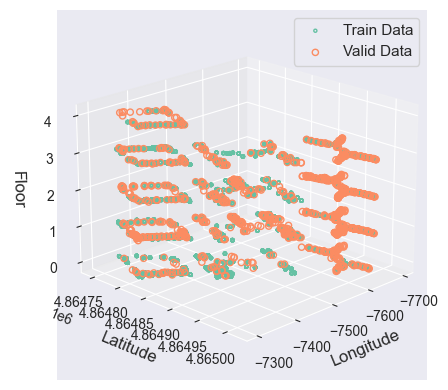

图像已保存至: ./performance/performance.png


<Figure size 640x480 with 0 Axes>

图像已保存至: ./performance/performance.png


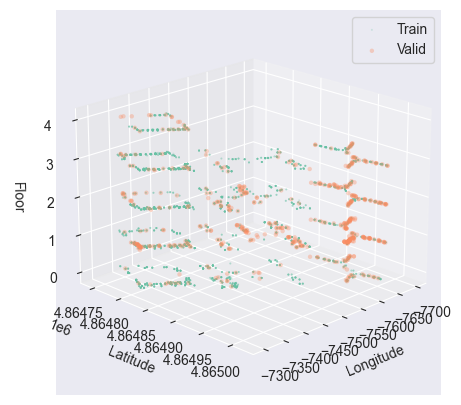

图像已保存至: ./performance/performance.png


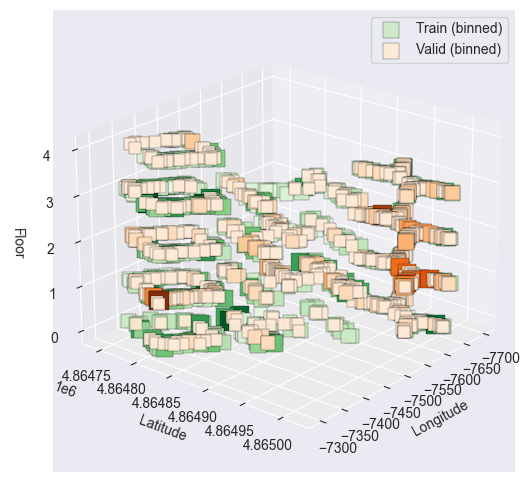

图像已保存至: ./performance/performance.png


<Figure size 640x480 with 0 Axes>

图像已保存至: ./performance/performance.png


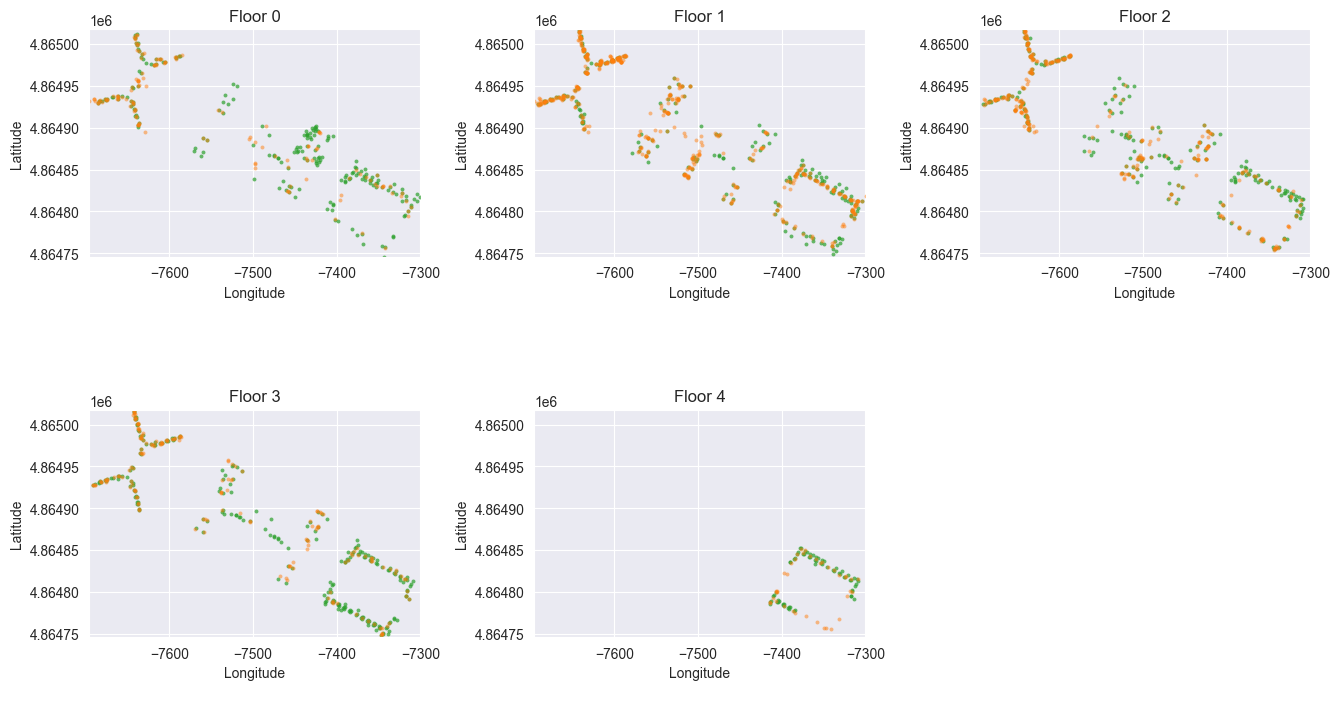

In [42]:
# 可视化对比
# 保存路径
save_path = './performance/performance.png'
visualize_sampling_3d(train_df, test_df, title='Original vs Grid Sampled (Train Set)', save_path=save_path)

# 方案 1：三维散点（随机下采样 + 半透明小点）
visualize_sampling_3d_better(
    train_df, test_df,
    # title='Original vs Grid Sampled (Train Set)',
    save_path=save_path,
    mode='scatter',        # 'scatter' | 'binned' | 'facets'
    max_points=8000        # 控制最多点数，避免密密麻麻
)

# 方案 2：三维网格聚合（推荐，总览清晰）
visualize_sampling_3d_better(
    train_df, test_df,
    # title='Original vs Grid Sampled (Train Set)',
    save_path=save_path,
    mode='binned',
    bin_size=2.0           # 经纬度的分箱大小，可调
)

# 方案 3：按楼层分面图（每层一张 2D hexbin）
visualize_sampling_3d_better(
    train_df, test_df,
    # title='The distribution of the training set and validation set on each floor',
    save_path=save_path,
    mode='facets'
)

In [25]:
# 将数据变成表格分析，训练集、测试集在各建筑（依照BUILDINGID）分布数量，建筑下的楼层数量，比如建筑号+楼层为标识
import pandas as pd

def analyze_building_floor_distribution(train_df, valid_df):
    # 创建标识列：例如 B0F1 表示建筑0楼层1
    train_df['B_F'] = train_df['BUILDINGID'].astype(str) + '_F' + train_df['FLOOR'].astype(str)
    valid_df['B_F'] = valid_df['BUILDINGID'].astype(str) + '_F' + valid_df['FLOOR'].astype(str)

    # 统计训练集分布
    train_counts = train_df.groupby(['BUILDINGID', 'FLOOR']).size().reset_index(name='Train_Count')

    # 统计验证集分布
    valid_counts = valid_df.groupby(['BUILDINGID', 'FLOOR']).size().reset_index(name='Valid_Count')

    # 合并结果
    merged_df = pd.merge(train_counts, valid_counts, on=['BUILDINGID', 'FLOOR'], how='outer').fillna(0)
    merged_df['Train_Count'] = merged_df['Train_Count'].astype(int)
    merged_df['Valid_Count'] = merged_df['Valid_Count'].astype(int)

    # 添加建筑+楼层标识列
    merged_df['B_F'] = 'B' + merged_df['BUILDINGID'].astype(str) + '_F' + merged_df['FLOOR'].astype(str)

    # 按建筑排序
    merged_df = merged_df.sort_values(by=['BUILDINGID', 'FLOOR']).reset_index(drop=True)

    return merged_df


In [26]:
# train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
# valid_df = pd.read_csv('../UJIIndoorLoc/validationData.csv')

distribution_df = analyze_building_floor_distribution(train_df, valid_df)

# 打印表格
print(distribution_df)

# 保存到 Excel 或 CSV
distribution_df.to_csv('./data/building_floor_distribution.csv', index=False)


    BUILDINGID  FLOOR  Train_Count  Valid_Count    B_F
0            0      0          827          232  B0_F0
1            0      1         1084          272  B0_F1
2            0      2         1142          301  B0_F2
3            0      3         1130          261  B0_F3
4            1      0         1088          280  B1_F0
5            1      1         1191          293  B1_F1
6            1      2         1119          277  B1_F2
7            1      3          762          186  B1_F3
8            2      0         1531          411  B2_F0
9            2      1         1721          441  B2_F1
10           2      2         1287          290  B2_F2
11           2      3         2174          535  B2_F3
12           2      4          893          209  B2_F4


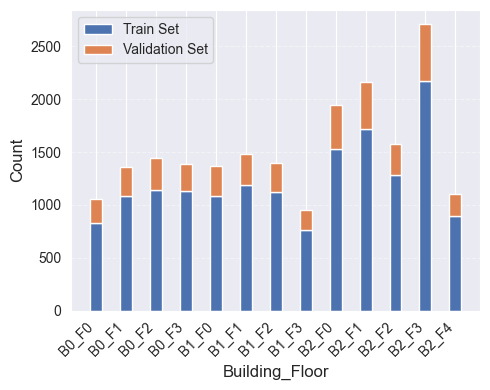

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取保存的统计表格（含 Building_Floor、Train_Count、Valid_Count）
df = pd.read_csv('./data/building_floor_distribution.csv')

# 横轴标签：Building_Floor（如：B0_F0）
labels = df['B_F']
x = np.arange(len(labels))  # x轴位置索引

# y轴数据
train_counts = df['Train_Count']
valid_counts = df['Valid_Count']

# 设置合适的长宽比例
fig, ax = plt.subplots(figsize=(5, 4))  # 宽18，高4

# 绘制堆叠柱状图
ax.bar(x, train_counts, width=0.4, label='Train Set', color='#4C72B0')
ax.bar(x, valid_counts, width=0.4, bottom=train_counts, label='Validation Set', color='#DD8452')

# 美化
ax.set_xlabel('Building_Floor', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
# ax.set_title('Stacked Sample Distribution per Building and Floor', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# 保存图像
plt.savefig('./performance/stacked_building_floor_distribution.png', dpi=300)
plt.show()


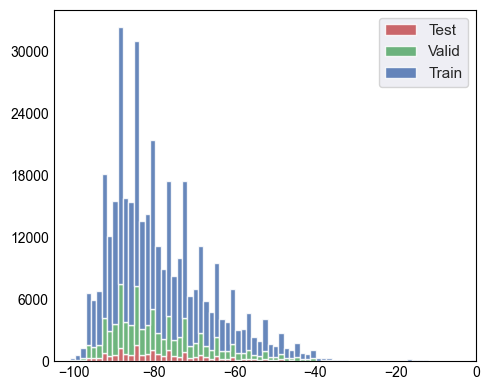

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

# 读取数据
train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
test_df  = pd.read_csv('../UJIIndoorLoc/validationData.csv')

# 分层抽样（按 SPACEID）
assert 'SPACEID' in train_df.columns, "SPACEID 不在列中，请检查数据。"
train_df, valid_df = train_test_split(
    train_df, test_size=0.2, random_state=42,
    stratify=train_df['SPACEID'].values
)

# 提取有效 RSSI（前 520 列，剔除 100）
def extract_valid_rssi(df):
    rssi = df.iloc[:, :520].values.flatten()
    return rssi[rssi != 100]

train_rssi = extract_valid_rssi(train_df)
valid_rssi = extract_valid_rssi(valid_df)
test_rssi  = extract_valid_rssi(test_df)

# bin
bins = np.linspace(-105, 0, 80)

# 画图
plt.figure(figsize=(5, 4))
plt.hist([test_rssi, valid_rssi, train_rssi],
         bins=bins, stacked=True,
         label=['Test', 'Valid', 'Train'],
         color=['#C44E52', '#55A868', '#4C72B0'],  # 如需灰度文档可去色
         alpha=0.85)

ax = plt.gca()
# 坐标轴范围与刻度
ax.set_xlim(-105, 0)
ax.set_xticks(np.arange(-100, 1, 20))          # 主刻度
ax.set_xticks(np.arange(-100, 1, 10), minor=True)  # 次刻度
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))

# 样式：保留轴与刻度，去网格、白背景
ax.grid(False)
ax.set_facecolor('white')
for spine in ['left', 'bottom', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.2, labelsize=10, colors='black')
ax.tick_params(axis='both', which='minor', direction='in', length=3, width=0.8, colors='black')
ax.tick_params(top=False, right=False)

plt.legend(fontsize=11)
plt.tight_layout()

# 保存前确保目录存在
os.makedirs('./performance', exist_ok=True)
plt.savefig('./performance/stacked_rssi_distribution_test_bottom.png', dpi=300, facecolor='white')
plt.show()


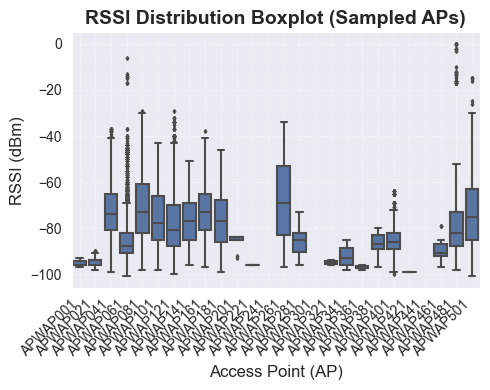

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')

# 取前 520 列 RSSI 数据
rssi_df = df.iloc[:, :520].replace(100, np.nan)  # 将无信号值替换为缺失

# 降采样：只画部分AP避免画太密，默认每隔20列取1列
sampled_rssi_df = rssi_df.iloc[:, ::20]

# 设置画图风格
plt.figure(figsize=(5, 4))
sns.boxplot(data=sampled_rssi_df, whis=1.5, fliersize=2, color='#4C72B0')

# 图形美化
plt.xticks(ticks=range(len(sampled_rssi_df.columns)),
           labels=[f"AP{idx}" for idx in sampled_rssi_df.columns],
           rotation=45, ha='right')
plt.title('RSSI Distribution Boxplot (Sampled APs)', fontsize=14, fontweight='bold')
plt.xlabel('Access Point (AP)', fontsize=12)
plt.ylabel('RSSI (dBm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# 保存图像（可选）
plt.savefig('./performance/rssi_boxplot_sampled_aps.png', dpi=300)
plt.show()


In [30]:
import pandas as pd
import numpy as np

# 读取数据（修改路径为你的本地路径）
train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
test_df = pd.read_csv('../UJIIndoorLoc/validationData.csv')

# 分层抽样划分 train / valid（按 SPACEID）
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['SPACEID']
)

print("训练集中 RSSI=0 的数量：", (train_rssi == -10).sum().sum())


# 提取 RSSI 数据（前 520 列）
train_rssi = train_df.iloc[:, :520].replace(100, np.nan)
valid_rssi = valid_df.iloc[:, :520].replace(100, np.nan)
test_rssi = test_df.iloc[:, :520].replace(100, np.nan)

train_rssi = train_rssi.replace([0, 100], np.nan)
valid_rssi = valid_rssi.replace([0, 100], np.nan)
test_rssi  = test_rssi.replace([0, 100], np.nan)


# 定义分析函数
def analyze_rssi(rssi_df):
    rssi_flat = rssi_df.values.flatten()
    valid_rssi = rssi_flat[~np.isnan(rssi_flat)]
    total_count = len(rssi_flat)
    missing_count = np.isnan(rssi_flat).sum()

    return {
        'Mean': np.mean(valid_rssi),
        'Std': np.std(valid_rssi),
        'Min': np.min(valid_rssi),
        'Max': np.max(valid_rssi),
        'Missing Rate (%)': 100 * missing_count / total_count
    }

# 分析每个数据集
summary = pd.DataFrame({
    'Train': analyze_rssi(train_rssi),
    'Valid': analyze_rssi(valid_rssi),
    'Test': analyze_rssi(test_rssi)
})

# 转置为表格形式展示
summary = summary.T
print(summary)

# 可选：保存为 Excel 或 CSV
summary.to_csv('./performance/rssi_stat_summary.csv')


训练集中 RSSI=0 的数量： 12
            Mean        Std    Min   Max  Missing Rate (%)
Train -78.548116  12.501710 -104.0  -1.0         96.535652
Valid -78.442919  12.615514 -103.0  -1.0         96.561270
Test  -77.683785  11.974915 -102.0 -34.0         96.831683
